Table of contents
1. [Precinct Shapefile](#shapefile)
2. [Election Results](#electionresults)
3. [Joining Election Results to Precinct Shapefile](#joining)
4. [Comparison to VEST](#comparison)

In [1482]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt

<a name="shapefile"></a>


# Precinct Shapefile

## VEST's Documentation File

Election results from Idaho Secretary of State (https://sos.idaho.gov/elections-division/election-results/). Absentee votes were reported countywide or by legislative district for Adams, Bannock, Blaine, Boise, Bonneville, Clearwater, Custer, Elmore, Franklin, Fremont, Gem, Gooding, Idaho, Jefferson, Jerome, Kootenai, Latah, Lemhi, Lewis, Madison, Minidoka, Nez Perce, Owyhee, Shoshone, Teton, Twin Falls, Valley. These were distributed by candidate to precincts based on their share of the precinct-level vote for the given reporting unit.

Precinct shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release, except the following counties used shapefiles sourced from the respective county governments instead: Ada, Adams, Bannock, Bingham, Boise, Bonner, Cassia, Clearwater, Custer, Fremont, Jefferson, Kootenai, Latah, Lemhi, Lewis, Madison, Minidoka, Nez Perce, Oneida, Power, Twin Falls, Valley.

County borders in all county-sourced shapefiles were aligned to the U.S Census Bureau's boundaries. The following additional modifications were made to match the 2018 precinct boundaries.

Ada: Merge 1817/1818
Bear Lake: Adjust most precincts to match county maps and voter file
Benewah: Boundaries revised countywide to match legal description
Bonner: Extend precincts over water and align with legal description
Boundary: Merge BF/Kootenai
Butte: Split Arco 1/Moore along USGS watershed line; Adjust Arco 1/2
Camas: Precinct numbers reversed based on county map
Cassia: Merge Burley 1/7
Clark: Adjust Precinct 1/2, 1/3
Elmore: Adjust Mountain Home 4/Hammett
Franklin: Split Cleveland/Mound Valley
Gem: Adjust Lincoln/Emerson, Hanna/West Emmett
Gooding: Align boundaries with PLSS grid and city limits
Idaho: Adjust Clearwater/Stites
Jerome: Split Canyonside/Rimrock
Latah: Merge 29/39; Adjust 19/29
Teton: Adjust precinct 6 to match Victor city limits
Washington: Align Weiser precincts with city limits
```
G18GOVRLIT - Brad Little (Republican Party)
G18GOVDJOR - Paulette Jordan (Democratic Party)
G18GOVLBOE - Bev "Angel" Boeck (Libertarian Party)
G18GOVCBAY - Walter L. Bayes (Constitution Party)
G18GOVOWRI - Write-in Votes

G18LTGRMCG - Janice McGeachin (Republican Party)
G18LTGDCOL - Kristin Collum (Democratic Party)

G18SOSRDEN - Lawerence E. Denney (Republican Party)
G18SOSDHUM - Jill Humble (Democratic Party)

G18CONRWOO - Brandon D. Woolf (Republican Party)

G18TRERELL - Julie A. Ellsworth (Republican Party)

G18ATGRWAS - Lawrence Wasden (Republican Party)
G18ATGDBIS - Bruce S. Bistline (Democratic Party)

G18SPIRYBA - Sherri Ybarra (Republican Party)
G18SPIDWIL - Cindy Wilson (Democratic Party)
```

## Load VEST's Final File

In [1483]:
vest_id_18 = gp.read_file("./raw-from-source/VEST/id_2018/id_2018.shp")

In [1484]:
vest_id_18.shape

(933, 20)

In [1485]:
vest_id_18.head(1)

,STATEFP,COUNTYFP,VTDST,NAME,G18GOVRLIT,G18GOVDJOR,G18GOVLBOE,G18GOVCBAY,G18GOVOWRI,G18LTGRMCG,G18LTGDCOL,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGRWAS,G18ATGDBIS,G18SPIRYBA,G18SPIDWIL,geometry
0,16,013,132601,16 Yale,8,0,0,0,0,7,0,7,0,7,7,8,0,5,0,"POLYGON Z ((-113.17891 42.75202 0.00000, -113...."


<AxesSubplot:>

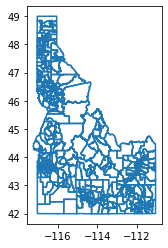

In [1486]:
vest_id_18.boundary.plot()

### Create a FIPS code dictionary

In [1487]:
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Idaho"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)
fips_file["unique_ID"] =  "16" + fips_file["FIPS County"]
fips_codes = fips_file["unique_ID"].tolist()
fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

In [1488]:
fips_dict

{'Ada': '001',
 'Adams': '003',
 'Bannock': '005',
 'Bear Lake': '007',
 'Benewah': '009',
 'Bingham': '011',
 'Blaine': '013',
 'Boise': '015',
 'Bonner': '017',
 'Bonneville': '019',
 'Boundary': '021',
 'Butte': '023',
 'Camas': '025',
 'Canyon': '027',
 'Caribou': '029',
 'Cassia': '031',
 'Clark': '033',
 'Clearwater': '035',
 'Custer': '037',
 'Elmore': '039',
 'Franklin': '041',
 'Fremont': '043',
 'Gem': '045',
 'Gooding': '047',
 'Idaho': '049',
 'Jefferson': '051',
 'Jerome': '053',
 'Kootenai': '055',
 'Latah': '057',
 'Lemhi': '059',
 'Lewis': '061',
 'Lincoln': '063',
 'Madison': '065',
 'Minidoka': '067',
 'Nez Perce': '069',
 'Oneida': '071',
 'Owyhee': '073',
 'Payette': '075',
 'Power': '077',
 'Shoshone': '079',
 'Teton': '081',
 'Twin Falls': '083',
 'Valley': '085',
 'Washington': '087'}

# Election Results

## Load in Election Results

Downloaded SOS Election Results using the same file linked by VEST, and cleaned them in Excel. Results do not require pivoting. 

In [1489]:
election_results = pd.read_csv('./raw-from-source/SOS/18gen_stwd_pct_clean.csv')

In [1490]:
election_results.head()

,County,Precinct,G18GOVCBAY,G18GOVLBOE,G18GOVDJOR,G18GOVRLIT,G18GOVOWRI,G18LTGDCOL,G18LTGRMCG,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGDBIS,G18ATGRWAS,G18SPIDWIL,G18SPIRYBA
0,ADA,1401,9,7,295,817,0,315,803,830,280,928,929,231,867,411,704
1,ADA,1402,5,7,356,1069,0,389,1037,1066,346,1184,1180,312,1101,512,905
2,ADA,1403,10,19,461,1067,0,499,1044,1081,445,1212,1212,376,1138,602,912
3,ADA,1404,14,15,329,944,0,333,944,976,301,1121,1123,297,975,464,812
4,ADA,1405,13,10,430,1015,0,433,1015,1043,396,1217,1223,354,1070,577,844


## Compare Election Result Totals

In [1491]:
races = [x for x in vest_shp.columns if 'G18' in x]
races

['G18GOVRLIT',
 'G18GOVDJOR',
 'G18GOVLBOE',
 'G18GOVCBAY',
 'G18GOVOWRI',
 'G18LTGRMCG',
 'G18LTGDCOL',
 'G18SOSRDEN',
 'G18SOSDHUM',
 'G18CONRWOO',
 'G18TRERELL',
 'G18ATGRWAS',
 'G18ATGDBIS',
 'G18SPIRYBA',
 'G18SPIDWIL']

### Compare Vote Totals

In [1492]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(election_results[i])
print(sum_var_1)
print(sum_var_2)

3907437
3907437


### Compare Race Totals

In [1493]:
for race in races:
    diff_val = sum(vest_id_18[race])-sum(election_results[race])
    if diff_val != 0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL : " + str(sum(vest_id_18[race])))

G18GOVRLIT: EQUAL : 361661
G18GOVDJOR: EQUAL : 231081
G18GOVLBOE: EQUAL : 6551
G18GOVCBAY: EQUAL : 5787
G18GOVOWRI: EQUAL : 51
G18LTGRMCG: EQUAL : 356507
G18LTGDCOL: EQUAL : 240355
G18SOSRDEN: EQUAL : 370654
G18SOSDHUM: EQUAL : 222037
G18CONRWOO: EQUAL : 465105
G18TRERELL: EQUAL : 465109
G18ATGRWAS: EQUAL : 384791
G18ATGDBIS: EQUAL : 203283
G18SPIRYBA: EQUAL : 305977
G18SPIDWIL: EQUAL : 288488


### More Detailed Vote Comparisons

### Create a FIPs dictionary for ID

In [1494]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Idaho"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Make FIPS County Name uppercase
fips_file['County Name']=fips_file['County Name'].str.upper()

#Create the dictionary
id_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

In [1495]:
id_fips_dict

{'ADA': '001',
 'ADAMS': '003',
 'BANNOCK': '005',
 'BEAR LAKE': '007',
 'BENEWAH': '009',
 'BINGHAM': '011',
 'BLAINE': '013',
 'BOISE': '015',
 'BONNER': '017',
 'BONNEVILLE': '019',
 'BOUNDARY': '021',
 'BUTTE': '023',
 'CAMAS': '025',
 'CANYON': '027',
 'CARIBOU': '029',
 'CASSIA': '031',
 'CLARK': '033',
 'CLEARWATER': '035',
 'CUSTER': '037',
 'ELMORE': '039',
 'FRANKLIN': '041',
 'FREMONT': '043',
 'GEM': '045',
 'GOODING': '047',
 'IDAHO': '049',
 'JEFFERSON': '051',
 'JEROME': '053',
 'KOOTENAI': '055',
 'LATAH': '057',
 'LEMHI': '059',
 'LEWIS': '061',
 'LINCOLN': '063',
 'MADISON': '065',
 'MINIDOKA': '067',
 'NEZ PERCE': '069',
 'ONEIDA': '071',
 'OWYHEE': '073',
 'PAYETTE': '075',
 'POWER': '077',
 'SHOSHONE': '079',
 'TETON': '081',
 'TWIN FALLS': '083',
 'VALLEY': '085',
 'WASHINGTON': '087'}

In [1496]:
election_results["County"].unique()

array(['ADA', 'ADAMS', 'BANNOCK', 'BEAR LAKE', 'BENEWAH', 'BINGHAM',
       'BLAINE', 'BOISE', 'BONNER', 'BONNEVILLE', 'BOUNDARY', 'BUTTE',
       'CAMAS', 'CANYON', 'CARIBOU', 'CASSIA', 'CLARK', 'CLEARWATER',
       'CUSTER', 'ELMORE', 'FRANKLIN', 'FREMONT', 'GEM', 'GOODING',
       'IDAHO', 'JEFFERSON', 'JEROME', 'KOOTENAI', 'LATAH', 'LEMHI',
       'LEWIS', 'LINCOLN', 'MADISON', 'MINIDOKA', 'NEZ PERCE', 'ONEIDA',
       'OWYHEE', 'PAYETTE', 'POWER', 'SHOSHONE', 'TETON', 'TWIN FALLS ',
       'VALLEY', 'WASHINGTON'], dtype=object)

In [1497]:
# Change column names to match the county fips dict
election_results.loc[election_results['County'] == 'TWIN FALLS ', 'County'] = 'TWIN FALLS'

#Map to the correct FIP
election_results["county"]=election_results["County"].map(id_fips_dict).fillna(election_results["County"])

#Print out the FIPS to make sure they all are in the correct format
election_results["county"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '055', '057', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087'],
      dtype=object)

In [1498]:
diff_counties=[]
for i in races:
    diff = election_results.groupby(["county"]).sum()[i]-vest_id_18.groupby(["COUNTYFP"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i+'\n'+ diff[diff != 0].to_string(header=False), 'NOT EQUAL')
    else:
        print(i + ' county totals: EQUAL')
        


G18GOVRLIT county totals: EQUAL
G18GOVDJOR county totals: EQUAL
G18GOVLBOE county totals: EQUAL
G18GOVCBAY county totals: EQUAL
G18GOVOWRI
003   -1
005    1 NOT EQUAL
G18LTGRMCG county totals: EQUAL
G18LTGDCOL county totals: EQUAL
G18SOSRDEN county totals: EQUAL
G18SOSDHUM county totals: EQUAL
G18CONRWOO county totals: EQUAL
G18TRERELL county totals: EQUAL
G18ATGRWAS county totals: EQUAL
G18ATGDBIS county totals: EQUAL
G18SPIRYBA county totals: EQUAL
G18SPIDWIL county totals: EQUAL


In [1499]:
election_results

,County,Precinct,G18GOVCBAY,G18GOVLBOE,G18GOVDJOR,G18GOVRLIT,G18GOVOWRI,G18LTGDCOL,G18LTGRMCG,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGDBIS,G18ATGRWAS,G18SPIDWIL,G18SPIRYBA,county
0,ADA,1401,9,7,295,817,0,315,803,830,280,928,929,231,867,411,704,001
1,ADA,1402,5,7,356,1069,0,389,1037,1066,346,1184,1180,312,1101,512,905,001
2,ADA,1403,10,19,461,1067,0,499,1044,1081,445,1212,1212,376,1138,602,912,001
3,ADA,1404,14,15,329,944,0,333,944,976,301,1121,1123,297,975,464,812,001
4,ADA,1405,13,10,430,1015,0,433,1015,1043,396,1217,1223,354,1070,577,844,001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,WASHINGTON,07 Midvale,9,5,36,344,0,37,351,344,44,365,357,36,352,80,310,087
968,WASHINGTON,08 Cambridge,0,3,84,379,0,84,377,381,78,411,410,77,374,150,313,087
969,WASHINGTON,09 Pioneer,5,3,140,214,0,140,215,228,129,288,284,121,231,162,198,087
970,WASHINGTON,10 Sunnyside,5,2,75,306,0,70,314,323,60,354,354,54,325,108,277,087


In [1500]:
vest_id_18["join_col"]=vest_id_18['COUNTYFP']+vest_id_18['NAME']
election_results["join_col"]=election_results["county"]+election_results["Precinct"]

In [1501]:
#Check to make sure that the join_col in both files is unique

print(len(election_results["join_col"]))
print(election_results["join_col"].value_counts().sum())

print(len(vest_id_18["join_col"]))
print(vest_id_18["join_col"].value_counts().sum())

972
972
933
933


### Add Zero Vote Precincts from VEST's File

In [1502]:
vest_id_18[vest_id_18['G18GOVRLIT'] == 0]

,STATEFP,COUNTYFP,VTDST,NAME,G18GOVRLIT,G18GOVDJOR,G18GOVLBOE,G18GOVCBAY,G18GOVOWRI,G18LTGRMCG,...,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGRWAS,G18ATGDBIS,G18SPIRYBA,G18SPIDWIL,geometry,join_col
453,16,011,113127,Bonneville 27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON Z ((-111.80360 43.28228 0.00000, -111....",011Bonneville 27


In [1503]:
election_results[election_results['G18GOVRLIT'] == 0]

,County,Precinct,G18GOVCBAY,G18GOVLBOE,G18GOVDJOR,G18GOVRLIT,G18GOVOWRI,G18LTGDCOL,G18LTGRMCG,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGDBIS,G18ATGRWAS,G18SPIDWIL,G18SPIRYBA,county,join_col
263,BINGHAM,Bonneville 27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,011,011Bonneville 27


Doesn't look like there's any zero vote precincts to add. 

In [1504]:
election_results=election_results[['County','Precinct','county','G18GOVRLIT','G18GOVDJOR','G18GOVLBOE','G18GOVCBAY','G18GOVOWRI','G18LTGRMCG','G18LTGDCOL','G18SOSRDEN','G18SOSDHUM','G18CONRWOO','G18TRERELL','G18ATGRWAS','G18ATGDBIS','G18SPIRYBA','G18SPIDWIL','join_col']]

In [1505]:
election_results[election_results['County'] == 'BONNEVILLE']

,County,Precinct,county,G18GOVRLIT,G18GOVDJOR,G18GOVLBOE,G18GOVCBAY,G18GOVOWRI,G18LTGRMCG,G18LTGDCOL,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGRWAS,G18ATGDBIS,G18SPIRYBA,G18SPIDWIL,join_col
321,BONNEVILLE,1,019,382,184,8,12,0,380,201,399,181,485,488,407,164,235,343,0191
322,BONNEVILLE,2,019,381,187,5,16,0,390,190,403,173,483,476,421,153,267,305,0192
323,BONNEVILLE,3,019,209,122,8,2,0,205,128,215,120,236,239,227,102,156,176,0193
324,BONNEVILLE,4,019,392,190,8,10,0,385,205,376,197,446,452,404,173,243,347,0194
325,BONNEVILLE,5,019,279,192,9,17,0,292,197,286,188,317,319,306,164,192,301,0195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,BONNEVILLE,59,019,485,101,5,9,0,474,122,489,99,508,487,550,77,360,277,01959
372,BONNEVILLE,Absentee 30,019,2196,1262,37,37,0,2139,1374,2176,1303,2406,2392,2300,1172,1832,1655,019Absentee 30
373,BONNEVILLE,Absentee 32,019,276,114,2,2,0,273,120,271,118,281,284,281,110,245,145,019Absentee 32
374,BONNEVILLE,Absentee 33,019,1676,1476,39,19,0,1535,1644,1584,1576,1898,1911,1736,1407,1298,1874,019Absentee 33


In [1506]:
vest_id_18[vest_id_18['COUNTYFP'] == '029']

,STATEFP,COUNTYFP,VTDST,NAME,G18GOVRLIT,G18GOVDJOR,G18GOVLBOE,G18GOVCBAY,G18GOVOWRI,G18LTGRMCG,...,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGRWAS,G18ATGDBIS,G18SPIRYBA,G18SPIDWIL,geometry,join_col
137,16,029,293208,Grace 2,208,28,2,7,0,206,...,202,39,230,228,214,29,137,105,"POLYGON Z ((-111.73511 42.43644 0.00000, -111....",029Grace 2
138,16,029,293209,Wayan,33,0,0,1,0,32,...,31,1,31,31,32,0,25,5,"POLYGON Z ((-111.40366 42.90741 0.00000, -111....",029Wayan
139,16,029,293201,Grace 1,345,64,4,5,0,341,...,345,69,392,380,352,60,217,194,"POLYGON Z ((-111.59418 42.46419 0.00000, -111....",029Grace 1
140,16,029,293207,Soda 1,308,78,4,7,0,306,...,312,82,356,358,317,66,246,141,"POLYGON Z ((-111.56373 42.65235 0.00000, -111....",029Soda 1
141,16,029,293202,Soda 2,261,81,6,9,0,250,...,258,86,299,300,264,84,186,162,"POLYGON Z ((-111.56393 42.80415 0.00000, -111....",029Soda 2
142,16,029,293206,Freedom,33,1,2,2,0,37,...,36,1,32,32,35,2,35,1,"POLYGON Z ((-111.21732 42.72682 0.00000, -111....",029Freedom
143,16,029,293203,Soda 3,177,41,2,7,0,170,...,167,55,202,200,179,42,128,96,"POLYGON Z ((-111.71928 42.65170 0.00000, -111....",029Soda 3
144,16,029,293204,Soda 4,191,43,3,2,0,188,...,201,36,217,217,196,38,153,83,"POLYGON Z ((-111.60531 42.64055 0.00000, -111....",029Soda 4
145,16,029,293205,Bancroft,268,35,3,6,0,261,...,268,40,286,280,264,40,193,109,"POLYGON Z ((-111.71234 42.67149 0.00000, -111....",029Bancroft


In [1507]:
election_results.shape

(972, 19)

In [1508]:
election_results.loc[election_results['Precinct'] == 'Absentee L28', 'Precinct'] = 'Absentee_L28'
election_results.loc[election_results['Precinct'] == 'Absentee L29', 'Precinct'] = 'Absentee_L29'
election_results.loc[election_results['Precinct'] == 'Absentee 30', 'Precinct'] = 'Absentee_L30'
election_results.loc[election_results['Precinct'] == 'Absentee 32', 'Precinct'] = 'Absentee_L32'
election_results.loc[election_results['Precinct'] == 'Absentee 33', 'Precinct'] = 'Absentee_L33'
election_results.loc[election_results['Precinct'] == 'Absentee 34', 'Precinct'] = 'Absentee_L34'
election_results.loc[election_results['Precinct'] == 'ABS Leg Dist 2 ', 'Precinct'] = 'Absentee_L2'
election_results.loc[election_results['Precinct'] == 'ABS Leg Dist 2 ATH', 'Precinct'] = 'Absentee_L2'
election_results.loc[election_results['Precinct'] == 'ABS Leg Dist 2 HAY', 'Precinct'] = 'Absentee_L2'
election_results.loc[election_results['Precinct'] == 'ABS Leg Dist 2 BVWS', 'Precinct'] = 'Absentee_L2'
election_results.loc[election_results['Precinct'] == 'ABS Leg Dist 3', 'Precinct'] = 'Absentee_L3'
election_results.loc[election_results['Precinct'] == 'ABS Leg Dist 4', 'Precinct'] = 'Absentee_L4'
election_results.loc[election_results['Precinct'] == 'Absentee 23', 'Precinct'] = 'Absentee_L23'
election_results.loc[election_results['Precinct'] == 'Absentee 24', 'Precinct'] = 'Absentee_L24'
election_results.loc[election_results['Precinct'] == 'Absentee 25', 'Precinct'] = 'Absentee_L25'
election_results=election_results.groupby(['County', 'Precinct','county'], as_index=False).agg('sum')
election_results["join_col"]=election_results["county"]+election_results["Precinct"]

In [1509]:
#List precincts in legistative districts for votes to be distributed
Absentee_L28 = ['Pocatello 34','Pocatello 35','Pocatello 36','Pocatello 37',
       'Pocatello 38','Pocatello 39','Pocatello 40','Pocatello 42',
       'Pocatello 43','Chubbuck 50','Chubbuck 51','Chubbuck 52',
       'Chubbuck 53','Chubbuck 54','Chubbuck 55','Chubbuck 56',
       'Chubbuck 57','Chubbuck 58','Chubbuck 59','Fort Hall 60',
       'Arimo 61','Downey 62','Inkom 63','Lava Hot Springs 64',
       'McCammon 65','Pebble Creek 67','Swan Lake 68','Absentee_L28']

Absentee_L29 = ['Pocatello 1','Pocatello 2','Pocatello 3','Pocatello 4',
       'Pocatello 5','Pocatello 6','Pocatello 9','Pocatello 10',
       'Pocatello 11','Pocatello 12','Pocatello 13','Pocatello 14',
       'Pocatello 15','Pocatello 17','Pocatello 18','Pocatello 19',
       'Pocatello 21','Pocatello 22','Pocatello 23','Pocatello 25',
       'Pocatello 26','Pocatello 27','Pocatello 28','Pocatello 32',
       'Mink Creek 66','Absentee_L29']

Absentee_L30 = ['1','21','22','23','24','25','26','27'
       ,'28','37','38','39','40','45','46',
       '47','48','49','50','51','52','53','57','Absentee_L30']

Absentee_L32 = ['55','56','58','59','Absentee_L32']

Absentee_L33 = ['2','3','4','5','6','7','8','9',
       '10','11','12','13','14','15',
       '16','17','18','19','20','Absentee_L33']

Absentee_L34 = ['41','42','43','44','54','Absentee_L34']

Absentee_L2 = ['1','2','3','4','5','6','7',
      '12','13','14','15','16','17',
      '18','19','20','21','22','41',
      '61','67','68','70','Absentee_L2']

Absentee_L3 = ['8','9','10','11','23','24',
      '25','26','27','28','29','30',
      '31','32','33','34','35','36',
      '63','64','65','66','69','Absentee_L3']

Absentee_L4 = ['37','38','39','40','42','43',
      '44','45','46','47','48','49',
      '50','51','52','53','54','55',
      '56','57','58','59','60','62','Absentee_L4']

Absentee_L23 = ['Buhl 1','Buhl 2','Castleford','Deep Creek','Maroa','Absentee_L23']

Absentee_L24 = ['Twin Falls 1','Twin Falls 2','Twin Falls 3','Twin Falls 4',
       'Twin Falls 5','Twin Falls 6','Twin Falls 7','Twin Falls 8',
       'Twin Falls 9','Twin Falls 10','Twin Falls 11','Twin Falls 12',
       'Twin Falls 13','Twin Falls 14','Twin Falls 15','Twin Falls 16',
       'Twin Falls 17','Twin Falls 18','Twin Falls 19','Twin Falls 20',
       'Twin Falls 21','Twin Falls 22','Twin Falls 23','Absentee_L24']

Absentee_L25 = ['Buhl 3','Buhl 4','Buhl 5','Filer 1','Filer 2','Filer 3',
       'Hansen','Hollister','Kimberly 1','Kimberly 2','Kimberly 3',
       'Kimberly 4','Murtaugh','Twin Falls 24','Twin Falls 25','Twin Falls 26','Absentee_L25']

In [1510]:
election_results.loc[(election_results['County']== 'BANNOCK') & election_results['Precinct'].isin(Absentee_L28), 'County'] = 'BANNOCK_L28'
election_results.loc[(election_results['County']== 'BANNOCK') & election_results['Precinct'].isin(Absentee_L29), 'County'] = 'BANNOCK_L29'
election_results.loc[(election_results['County']== 'BONNEVILLE') & election_results['Precinct'].isin(Absentee_L30), 'County'] = 'BONNEVILLE_L30'
election_results.loc[(election_results['County']== 'BONNEVILLE') & election_results['Precinct'].isin(Absentee_L32), 'County'] = 'BONNEVILLE_L32'
election_results.loc[(election_results['County']== 'BONNEVILLE') & election_results['Precinct'].isin(Absentee_L33), 'County'] = 'BONNEVILLE_L33'
election_results.loc[(election_results['County']== 'BONNEVILLE') & election_results['Precinct'].isin(Absentee_L34), 'County'] = 'BONNEVILLE_L34'
election_results.loc[(election_results['County']== 'KOOTENAI') & election_results['Precinct'].isin(Absentee_L2), 'County'] = 'KOOTENAI_L2'
election_results.loc[(election_results['County']== 'KOOTENAI') & election_results['Precinct'].isin(Absentee_L3), 'County'] = 'KOOTENAI_L3'
election_results.loc[(election_results['County']== 'KOOTENAI') & election_results['Precinct'].isin(Absentee_L4), 'County'] = 'KOOTENAI_L4'
election_results.loc[(election_results['County']== 'TWIN FALLS') & election_results['Precinct'].isin(Absentee_L23), 'County'] = 'TWIN FALLS_L23'
election_results.loc[(election_results['County']== 'TWIN FALLS') & election_results['Precinct'].isin(Absentee_L24), 'County'] = 'TWIN FALLS_L24'
election_results.loc[(election_results['County']== 'TWIN FALLS') & election_results['Precinct'].isin(Absentee_L25), 'County'] = 'TWIN FALLS_L25'

In [1511]:
pd.set_option('display.max_rows', None)
print(election_results[election_results['County'] == 'BONNEVILLE_L30'])
pd.set_option('display.max_rows', 10)

             County      Precinct county  G18GOVRLIT  G18GOVDJOR  G18GOVLBOE  \
321  BONNEVILLE_L30             1    019         382         184           8   
334  BONNEVILLE_L30            21    019         467         213          10   
335  BONNEVILLE_L30            22    019         398         133           9   
336  BONNEVILLE_L30            23    019         406         140           5   
337  BONNEVILLE_L30            24    019         478         183           9   
338  BONNEVILLE_L30            25    019         359         168           8   
339  BONNEVILLE_L30            26    019         477         199           6   
340  BONNEVILLE_L30            27    019         434         142           8   
341  BONNEVILLE_L30            28    019         382         111           9   
343  BONNEVILLE_L30            37    019         366          74           4   
344  BONNEVILLE_L30            38    019         401         135           4   
345  BONNEVILLE_L30            39    019

### Deal with the countywide votes in the recreated file

#### Make a df with the countywide votes and their totals

In [1512]:
#Create a list of the all the different names used for these types of votes
#These were find in comparing the names present in both files
filter_out_list = [x for x in election_results['Precinct'].unique() if 'Absentee' in x or 'ABSENTEE' in x or 'ABS Leg Dist' in x]
filter_out_list

['007 Absentee',
 'Absentee_L28',
 'Absentee_L29',
 '017 Absentee',
 'Absentee',
 'Absentee_L30',
 'Absentee_L32',
 'Absentee_L33',
 'Absentee_L34',
 '028 Absentee',
 'Absentee_L2',
 'Absentee_L3',
 'Absentee_L4',
 'Absentee 36',
 '010 Absentee',
 'Absentee_L23',
 'Absentee_L24',
 'Absentee_L25']

In [1513]:
#Create a df of just these precincts
to_dole_out = election_results[election_results["Precinct"].isin(filter_out_list)]
to_dole_out

,County,Precinct,county,G18GOVRLIT,G18GOVDJOR,G18GOVLBOE,G18GOVCBAY,G18GOVOWRI,G18LTGRMCG,G18LTGDCOL,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGRWAS,G18ATGDBIS,G18SPIRYBA,G18SPIDWIL,join_col
156,ADAMS,007 Absentee,003,262,148,2,3,0,274,140,288,126,316,313,281,127,263,149,003007 Absentee
157,BANNOCK_L28,Absentee_L28,005,1891,1740,29,45,1,1798,1894,1879,1783,2792,2798,1925,1744,1587,2088,005Absentee_L28
158,BANNOCK_L29,Absentee_L29,005,1568,2622,54,36,0,1540,2730,1632,2617,2879,2875,1665,2564,1408,2855,005Absentee_L29
281,BLAINE,017 Absentee,013,1254,3804,36,11,0,1245,3822,1381,3669,2981,3076,1468,3548,1212,3819,013017 Absentee
288,BOISE,Absentee,015,435,276,4,4,0,440,277,457,256,549,547,458,253,415,296,015Absentee
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,TETON,Absentee,081,820,1408,17,10,0,811,1429,853,1374,1247,1246,882,1313,788,1440,081Absentee
902,TWIN FALLS_L23,Absentee_L23,083,266,92,4,4,0,264,97,263,94,289,289,273,84,239,119,083Absentee_L23
903,TWIN FALLS_L24,Absentee_L24,083,2666,1654,46,51,0,2592,1772,2702,1649,3225,3242,2882,1468,2391,1962,083Absentee_L24
904,TWIN FALLS_L25,Absentee_L25,083,1362,552,26,22,0,1341,609,1390,548,1590,1585,1449,488,1226,707,083Absentee_L25


In [1514]:
#Create a new df with the county-by-county totals of these precincts and reset the index 
to_dole_out_totals = pd.DataFrame(to_dole_out.groupby(["County"]).sum())
to_dole_out_totals.reset_index(inplace=True,drop=False)

#### Filter out the countywide precincts from the original dataframe and get the precinct-level vote totals by county

In [1515]:
#Filter out the countywide votes from the dataframe so we can iterate over just the remaining precincts and add votes
filtered_election = election_results[~election_results["Precinct"].isin(filter_out_list)]

#Create a df with the county-by-county sums of precinct-level votes, this will be used in the allocation, clean the index
precinct_specific_totals = pd.DataFrame(filtered_election.groupby(["County"]).sum())
precinct_specific_totals.reset_index(inplace=True,drop=False)
filtered_election.reset_index(inplace=True,drop=True)

#Look at both dfs to get a sense for what they show
print(precinct_specific_totals.head())
print(to_dole_out_totals.head())

        County  G18GOVRLIT  G18GOVDJOR  G18GOVLBOE  G18GOVCBAY  G18GOVOWRI  \
0          ADA       92684       94772        1943        1086          17   
1        ADAMS        1026         431          20          14           0   
2  BANNOCK_L28        6753        3751         140         140           0   
3  BANNOCK_L29        4763        5273         163         117           0   
4    BEAR LAKE        1780         307          25          39           0   

   G18LTGRMCG  G18LTGDCOL  G18SOSRDEN  G18SOSDHUM  G18CONRWOO  G18TRERELL  \
0       88189       99311       95073       90389      131433      131838   
1        1045         410        1090         372        1225        1227   
2        6746        3890        7041        3539        9156        9163   
3        4897        5279        5161        4952        8117        8100   
4        1779         356        1778         355        1998        2004   

   G18ATGRWAS  G18ATGDBIS  G18SPIRYBA  G18SPIDWIL  
0      102150   

#### Allocate the countywide votes

In [1516]:
to_dole_out['County']

156             ADAMS
157       BANNOCK_L28
158       BANNOCK_L29
281            BLAINE
288             BOISE
            ...      
901             TETON
902    TWIN FALLS_L23
903    TWIN FALLS_L24
904    TWIN FALLS_L25
957            VALLEY
Name: County, Length: 36, dtype: object

In [1517]:
races=['G18GOVRLIT','G18GOVDJOR','G18GOVLBOE','G18GOVCBAY','G18GOVOWRI',
       'G18LTGRMCG','G18LTGDCOL','G18SOSRDEN','G18SOSDHUM','G18CONRWOO',
       'G18TRERELL','G18ATGRWAS','G18ATGDBIS','G18SPIRYBA','G18SPIDWIL']


#Create some new columns for each of these races to deal with the allocation
for race in races:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    filtered_election.loc[:,add_var]=0.0
    filtered_election.loc[:,rem_var]=0.0
    filtered_election.loc[:,floor_var]=0.0

#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
for index, row in filtered_election.iterrows():
    #No countywide votes for 510
    if row["County"] in to_dole_out['County'].unique():
        for race in races:
           
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #Grab the county
            county_id = row["County"]
            #Get the denominator for the allocation (the precinct vote totals)
            denom = precinct_specific_totals.loc[precinct_specific_totals["County"]==county_id][race]
            #Get one of the numerators, how many countywide votes to allocate
            numer = to_dole_out_totals.loc[to_dole_out_totals["County"]==county_id][race]
            
            #Get the vote totals for this race in this precinct
            val = filtered_election.at[index,race]
            
            #Get the vote share, the precincts % of total precinct votes in the county times votes to allocate
            if float(denom) !=0:
                vote_share = (float(val)/float(denom))*float(numer)
            else:
                vote_share = 0
            
            
            filtered_election.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            filtered_election.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            filtered_election.at[index,floor_var] = np.floor(vote_share)
            

#After the first pass through, get the sums of the races by county            
first_allocation = pd.DataFrame(filtered_election.groupby(["County"]).sum())

#Now we want to iterate county by county to work on rounding
county_list = list(to_dole_out_totals["County"].unique()) 

#Iterate over the counties
for county in county_list:
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["County"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in filtered_election.loc[filtered_election["County"]==county][rem_var].nlargest(to_go).index:
            filtered_election.at[index,add_var] = np.ceil(filtered_election.at[index,add_var])

#Iterate over every race again
for race in races:
    add_var = race+"_add"
    #Round every allocation down
    filtered_election.loc[:,add_var]=np.floor(filtered_election.loc[:,add_var])
    #Add every allocation to the total
    filtered_election.loc[:,race]+=filtered_election.loc[:,add_var]

    
#Filter back down to the original columns
filtered_election = filtered_election[list(election_results.columns)]


C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [1518]:
filtered_election['County'].unique()

array(['ADA', 'ADAMS', 'BANNOCK_L28', 'BANNOCK_L29', 'BEAR LAKE',
       'BENEWAH', 'BINGHAM', 'BLAINE', 'BOISE', 'BONNER',
       'BONNEVILLE_L30', 'BONNEVILLE_L33', 'BONNEVILLE_L34',
       'BONNEVILLE_L32', 'BOUNDARY', 'BUTTE', 'CAMAS', 'CANYON',
       'CARIBOU', 'CASSIA', 'CLARK', 'CLEARWATER', 'CUSTER', 'ELMORE',
       'FRANKLIN', 'FREMONT', 'GEM', 'GOODING', 'IDAHO', 'JEFFERSON',
       'JEROME', 'KOOTENAI_L2', 'KOOTENAI_L3', 'KOOTENAI_L4', 'LATAH',
       'LEMHI', 'LEWIS', 'LINCOLN', 'MADISON', 'MINIDOKA', 'NEZ PERCE',
       'ONEIDA', 'OWYHEE', 'PAYETTE', 'POWER', 'SHOSHONE', 'TETON',
       'TWIN FALLS_L23', 'TWIN FALLS_L25', 'TWIN FALLS_L24', 'VALLEY',
       'WASHINGTON'], dtype=object)

In [1519]:
filtered_election['County'] = filtered_election['County'].apply(lambda x: x.split('_')[0])

In [1520]:
filtered_election['County'].unique()

array(['ADA', 'ADAMS', 'BANNOCK', 'BEAR LAKE', 'BENEWAH', 'BINGHAM',
       'BLAINE', 'BOISE', 'BONNER', 'BONNEVILLE', 'BOUNDARY', 'BUTTE',
       'CAMAS', 'CANYON', 'CARIBOU', 'CASSIA', 'CLARK', 'CLEARWATER',
       'CUSTER', 'ELMORE', 'FRANKLIN', 'FREMONT', 'GEM', 'GOODING',
       'IDAHO', 'JEFFERSON', 'JEROME', 'KOOTENAI', 'LATAH', 'LEMHI',
       'LEWIS', 'LINCOLN', 'MADISON', 'MINIDOKA', 'NEZ PERCE', 'ONEIDA',
       'OWYHEE', 'PAYETTE', 'POWER', 'SHOSHONE', 'TETON', 'TWIN FALLS',
       'VALLEY', 'WASHINGTON'], dtype=object)

#### Check the allocation by making sure the vote totals still equal one another

In [1521]:
for race in races:
    diff_val = sum(vest_shp[race])-sum(filtered_election[race])
    if diff_val!=0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL : " + str(sum(vest_id_18[race])))

G18GOVRLIT: EQUAL : 361661
G18GOVDJOR: EQUAL : 231081
G18GOVLBOE: EQUAL : 6551
G18GOVCBAY: EQUAL : 5787
G18GOVOWRI: 1.0
G18LTGRMCG: EQUAL : 356507
G18LTGDCOL: EQUAL : 240355
G18SOSRDEN: EQUAL : 370654
G18SOSDHUM: EQUAL : 222037
G18CONRWOO: EQUAL : 465105
G18TRERELL: EQUAL : 465109
G18ATGRWAS: EQUAL : 384791
G18ATGDBIS: EQUAL : 203283
G18SPIRYBA: EQUAL : 305977
G18SPIDWIL: EQUAL : 288488


In [1522]:
print(sum(vest_shp['G18GOVOWRI']))
sum(filtered_election['G18GOVOWRI'])

51


50.0

In [1523]:
filtered_election['join_col'] = filtered_election['join_col'].str.upper()
vest_id_18['join_col'] = vest_id_18['join_col'].str.upper()

## Attempt Join

In [1524]:
join_attempt_one = pd.merge(filtered_election,vest_id_18,how="outer",on="join_col",indicator=True)
print(join_attempt_one["_merge"].value_counts())

both          569
left_only     364
right_only    364
Name: _merge, dtype: int64


In [1525]:
join_attempt_one.columns

Index(['County', 'Precinct', 'county', 'G18GOVRLIT_x', 'G18GOVDJOR_x',
       'G18GOVLBOE_x', 'G18GOVCBAY_x', 'G18GOVOWRI_x', 'G18LTGRMCG_x',
       'G18LTGDCOL_x', 'G18SOSRDEN_x', 'G18SOSDHUM_x', 'G18CONRWOO_x',
       'G18TRERELL_x', 'G18ATGRWAS_x', 'G18ATGDBIS_x', 'G18SPIRYBA_x',
       'G18SPIDWIL_x', 'join_col', 'STATEFP', 'COUNTYFP', 'VTDST', 'NAME',
       'G18GOVRLIT_y', 'G18GOVDJOR_y', 'G18GOVLBOE_y', 'G18GOVCBAY_y',
       'G18GOVOWRI_y', 'G18LTGRMCG_y', 'G18LTGDCOL_y', 'G18SOSRDEN_y',
       'G18SOSDHUM_y', 'G18CONRWOO_y', 'G18TRERELL_y', 'G18ATGRWAS_y',
       'G18ATGDBIS_y', 'G18SPIRYBA_y', 'G18SPIDWIL_y', 'geometry', '_merge'],
      dtype='object')

In [1526]:
pd.set_option('display.max_rows', 10)
join_attempt_one[join_attempt_one['_merge'] != 'both'][['COUNTYFP','NAME','county','Precinct','join_col']]

,COUNTYFP,NAME,county,Precinct,join_col
170,NaN,NaN,005,Lava Hot Springs 64,005LAVA HOT SPRINGS 64
208,NaN,NaN,007,#1 Montpelier,007#1 MONTPELIER
209,NaN,NaN,007,#10 Geneva/Pegram,007#10 GENEVA/PEGRAM
210,NaN,NaN,007,#11 Georgetown,007#11 GEORGETOWN
211,NaN,NaN,007,#12 Liberty,007#12 LIBERTY
...,...,...,...,...,...
1292,049,Elk City,NaN,NaN,049ELK CITY
1293,079,03 - WALLACE,NaN,NaN,07903 - WALLACE
1294,079,01 - MURRAY,NaN,NaN,07901 - MURRAY
1295,079,13 - AVERY (Mail Out),NaN,NaN,07913 - AVERY (MAIL OUT)


In [1527]:
filtered_election['join_col']=filtered_election['join_col'].str.strip()
vest_id_18['join_col']=vest_id_18['join_col'].str.strip()
#Define a name change dictionary, this was found by checking votes and then manually verifying each change
source_vest_names_dict = {'005LAVA HOT SPRINGS 64': '005LAVE HOT SPRINGS 64',
 '007#16 BAILEY CREEK': '007BAILEY CREEK',
 '007#5 BENNINGTON': '007BENNINGTON',
 '007#6 BERN': '007BERN',
 '007#7 BLOOMINGTON': '007BLOOMINGTON',
 '007#8 DINGLE': '007DINGLE',
 '007#9 FISH HAVEN': '007FISH HAVEN',
 '007#10 GENEVA/PEGRAM': '007GENEVA/PEGRAM',
 '007#11 GEORGETOWN': '007GEORGETOWN',
 '007#12 LIBERTY': '007LIBERTY',
 '007#1 MONTPELIER': '007MONTPELIER 1',
 '007#2 MONTPELIER': '007MONTPELIER 2',
 '007#3 MONTPELIER': '007MONTPELIER 3',
 '007#17 OVID/LANARK': '007OVID/LANARK',
 '007#13 PARIS': '007PARIS',
 '007#15 ST. CHARLES': '007ST CHARLES',
 '0091 BENEWAH': '009BENEWAH',
 '0092 CENTER': '009CENTER',
 '0093 COLLEGE': '009COLLEGE',
 '0094 EMIDA': '009EMIDA',
 '0095 FERNWOOD': '009FERNWOOD',
 '0096 PLUMMER': '009PLUMMER',
 '0097 SANTA': '009SANTA',
 '0098 ST. JOE': '009ST JOE',
 '0099 ST. MARIES': '009ST MARIES',
 '00910 TENSED': '009TENSED',
 '00911 TOWNSITE': '009TOWNSITE',
 '011SHELLEY 21': '011SHELLEY WEST 21',
 '011SPRINGFIELD/STERLING 16': '011SPRINGFIELD-STERLING 16',
 '013001 N BLAINE COUNTY': '0131 NORTH BLAINE COUNTY',
 '013010 NW WOODSIDE': '01310 NW WOODSIDE',
 '013011 SE WOODSIDE': '01311 SE WOODSIDE',
 '013012 POVERTY FLAT': '01312 POVERTY FLAT',
 '013013 BELLEVUE': '01313 BELLEVUE',
 '013014 CAREY': '01314 CAREY',
 '013015 GANNETT/PICABO': '01315 GANNETT/PICABO',
 '013016 YALE': '01316 YALE',
 '013002 SUN VALLEY': '0132 SUN VALLEY',
 '013003 N KETCHUM': '0133 NORTH KETCHUM',
 '013004 S KETCHUM': '0134 SOUTH KETCHUM',
 '013005 QUIGLEY': '0135 QUIGLEY',
 '013006 DEER CREEK': '0136 DEER CREEK',
 '013007 NW HAILEY': '0137 NW HAILEY',
 '013008 NE HAILEY': '0138 NE HAILEY',
 '013009 SW HAILEY': '0139 SW HAILEY',
 '01530 GARDEN VALLEY': '015GARDEN VALLEY',
 '01540 HORSESHOE BEND': '015HORSESHOE BEND',
 '01550 IDAHO CITY': '015IDAHO CITY',
 '01560 LOWMAN': '015LOWMAN',
 '01570 MORES CREEK': '015MORES CREEK',
 '01580 PLACERVILLE': '015PLACERVILLE',
 '017EAST PRIEST RIVER': '017E PRIEST RIVER',
 '017WEST PRIEST RIVER': '017W PRIEST RIVER',
 '021MOYIE SPRINGS': '021MOYIE',
 '023HOWE 4': '023HOWE',
 '023MOORE 3': '023MOORE',
 '025#1': '025PRECINCT 1',
 '025#2': '025PRECINCT 2',
 '0279-JAN': '0271',
 '0279-FEB': '0272',
 '0279-MAR': '0273',
 '02710-JUL': '0277',
 '02710-AUG': '0278',
 '02710-SEP': '0279',
 '02710-OCT': '02710',
 '02710-NOV': '02711',
 '02710-DEC': '02712',
 '02713-10': '02713',
 '02714-10': '02714',
 '02715-10': '02715',
 '02716-10': '02716',
 '02717-10': '02717',
 '02718-10': '02718',
 '02719-10': '02719',
 '02720-10': '02720',
 '02726-11': '02726',
 '02727-11': '02727',
 '02728-11': '02728',
 '02729-11': '02729',
 '02730-11': '02730',
 '02731-11': '02731',
 '02732-11': '02732',
 '02733-11': '02733',
 '02734-11': '02734',
 '02735-11': '02735',
 '02736-11': '02736',
 '02737-11': '02737',
 '02738-11': '02738',
 '02739-11': '02739',
 '02740-11': '02740',
 '02741-11': '02741',
 '02742-11': '02742',
 '02743-11': '02743',
 '02744-11': '02744',
 '02749-12': '02749',
 '02750-12': '02750',
 '02751-12': '02751',
 '02752-12': '02752',
 '02753-12': '02753',
 '02754-12': '02754',
 '02755-12': '02755',
 '02756-12': '02756',
 '02757-12': '02757',
 '02758-12': '02758',
 '02759-12': '02759',
 '02760-12': '02760',
 '02761-12': '02761',
 '02762-12': '02762',
 '02769-13': '02769',
 '02770-13': '02770',
 '02771-13': '02771',
 '02772-13': '02772',
 '02773-13': '02773',
 '02774-13': '02774',
 '02775-13': '02775',
 '02776-13': '02776',
 '02777-13': '02777',
 '02778-13': '02778',
 '02779-13': '02779',
 '02780-13': '02780',
 '02781-13': '02781',
 '02782-13': '02782',
 '029GRACE #1': '029GRACE 1',
 '029GRACE #2': '029GRACE 2',
 '029SODA #1': '029SODA 1',
 '029SODA #3': '029SODA 3',
 '029SODA #4': '029SODA 4',
 '029SODA#2': '029SODA 2',
 "031STARRAH'S FERRY": "031STARRAH'S",
 '033#1': '033PRECINCT 1',
 '033#2': '033PRECINCT 2',
 '033#3': '033PRECINCT 3',
 '037CHALLIS': '037CHALLIS 1',
 '039MOUNTAIN HOME 1': '039MOUNTAIN HOME #1',
 '039MOUNTAIN HOME 2': '039MOUNTAIN HOME #2',
 '039MOUNTAIN HOME 3': '039MOUNTAIN HOME #3',
 '039MOUNTAIN HOME 4': '039MOUNTAIN HOME #4',
 '039MOUNTAIN HOME 5': '039MOUNTAIN HOME #5',
 '039MOUNTAIN HOME 6': '039MOUNTAIN HOME #6',
 '039MOUNTAIN HOME 7': '039MOUNTAIN HOME #7',
 '039MOUNTAIN HOME 8': '039MOUNTAIN HOME #8',
 '039MOUNTAIN HOME 9': '039MOUNTAIN HOME #9',
 '039PINE': '039PINE',
 '041BANIDA #6': '041BANIDA 6',
 '041CLEVELAND #13': '041CLEVELAND 13',
 '041CLIFTON #7': '041CLIFTON 7',
 '041DAYTON #8': '041DAYTON 8',
 '041FAIRVIEW #9': '041FAIRVIEW 9',
 '041FRANKLIN #10': '041FRANKLIN 10',
 '041MAPLETON #11': '041MAPLETON 11',
 '041MINK CREEK #12': '041MINK CREEK 12',
 '041MOUND VALLEY #18': '041MOUND VALLEY 18',
 '041PRESTON #1': '041PRESTON 1',
 '041PRESTON #2': '041PRESTON 2',
 '041PRESTON #3': '041PRESTON 3',
 '041PRESTON #4': '041PRESTON 4',
 '041PRESTON #5': '041PRESTON 5',
 '041TREASURETON #14': '041TREASURETON 14',
 '041WESTON #15': '041WESTON 15',
 '041WHITNEY #16': '041WHITNEY 16',
 '041WORM CREEK #17': '041WORM CREEK 17',
 '04511 BENCH': '045BENCH',
 '04510 BRICK': '045BRICK',
 '04503 BUTTEVIEW': '045BUTTEVIEW',
 '04501 CENTRAL': '045CENTRAL EMMETT',
 '04506 EMERSON': '045EMERSON',
 '04509 HANNA': '045HANNA',
 '04508 LETHA': '045LETHA',
 '04507 LINCOLN': '045LINCOLN',
 '04502 NORTH EMMETT': '045NORTH EMMETT',
 '04513 OLA': '045OLA',
 '04504 SOUTH EMMETT': '045SOUTH EMMETT',
 '04512 SWEET/MONTOUR': '045SWEET-MONTOUR',
 '04505 WEST EMMETT': '045WEST EMMETT',
 '049001 BIG BUTTE': '049BIG BUTTE',
 '049002 CLEARWATER': '049CLEARWATER',
 '049003 COTTONWOOD #1': '049COTTONWOOD #1',
 '049004 COTTONWOOD #2': '049COTTONWOOD #2',
 '049005 ELK CITY': '049ELK CITY',
 '049006 FENN': '049FENN',
 '049007 FERDINAND': '049FERDINAND',
 '049009 GLOVER': '049GLOVER',
 '049010 GRANGEVILLE #1': '049GRANGEVILLE #1',
 '049011 GRANGEVILLE #2': '049GRANGEVILLE #2',
 '049012 GRANGEVILLE #3': '049GRANGEVILLE #3',
 '049013 GRANGEVILLE #4': '049GRANGEVILLE #4',
 '049014 GRANGEVILLE #5': '049GRANGEVILLE #5',
 '049008 GREENCREEK': '049GREENCREEK',
 '049015 HARPSTER': '049HARPSTER',
 '049016 JOSEPH': '049JOSEPH',
 '049017 KAMIAH': '049KAMIAH',
 '049018 KEUTERVILLE': '049KEUTERVILLE',
 '049019 KOOSKIA': '049KOOSKIA',
 '049020 LOWELL': '049LOWELL',
 '049021 POLLOCK': '049POLLOCK',
 '049022 RIGGINS': '049RIGGINS',
 '049023 SLATE CREEK 1': '049SLATE CREEK I',
 '049027 SLATE CREEK 2': '049SLATE CREEK II',
 '049024 STITES': '049STITES',
 '049025 WHITE BIRD': '049WHITE BIRD',
 '049026 WOODLAND': '049WOODLAND',
 '0511 ANNIS': '051ANNIS',
 '0512 CLARK': '051CLARK',
 '0513 GARFIELD': '051GARFIELD',
 '0514 GRANT': '051GRANT',
 '0515 HAMER': '051HAMER',
 '0516 LABELLE': '051LABELLE',
 '0517 LEWISVILLE': '051LEWISVILLE',
 '0518 LORENZO': '051LORENZO',
 '0519 MENAN': '051MENAN',
 '05110 MONTEVIEW': '051MONTEVIEW',
 '05111 RIGBY 1': '051RIGBY 1',
 '05112 RIGBY 2': '051RIGBY 2',
 '05113 RIGBY 3': '051RIGBY 3',
 '05114 RIGBY 4': '051RIGBY 4',
 '05115 RIGBY 5': '051RIGBY 5',
 '05116 RIGBY 6': '051RIGBY 6',
 '05117 RIGBY 7': '051RIGBY 7',
 '05118 RIRIE': '051RIRIE',
 '05119 ROBERTS': '051ROBERTS',
 '05120 TERRETON': '051TERRETON',
 '053001 BISHOP-COURT': '053BISHOP COURT',
 '053002 CANYONSIDE': '053CANYONSIDE',
 '053003 EDEN': '053EDEN',
 '053004 FALLS CITY': '053FALLS CITY',
 '053005 HAZELTON': '053HAZELTON',
 '053006 NORTHEAST': '053NORTHEAST',
 '053007 NORTHWEST': '053NORTHWEST',
 '053008RIMROCK': '053RIMROCK',
 '053009 SHEPHERDVIEW': '053SHEPHERDVIEW',
 '053010 SOUTHEAST': '053SOUTHEAST',
 '053011 SOUTHWEST': '053SOUTHWEST',
 '057PALOUSE 26': '057PALOUSE 26',
 '059003 BROOKLYN': '059BROOKLYN',
 '059002 DEPOT': '059DEPOT',
 '059006 IRON CREEK': '059IRON CREEK',
 '059009 JUNCTION': '059JUNCTION',
 '059008 LEMHI': '059LEMHI',
 '059005 MINERAL HILL': '059MINERAL HILL',
 '059004 NORTH FORK': '059NORTH FORK',
 '059007 PAHSIMEROI': '059PAHSIMEROI',
 '059001 SALMON': '059SALMON',
 '061004 CRAIGMONT': '061CRAIGMONT',
 '061003 EAST KAMIAH': '061EAST KAMIAH',
 '061007 MOHLER': '061MOHLER',
 '061001 NEZPERCE': '061NEZPERCE',
 '061006 REUBENS': '061REUBENS',
 '061008 SLICKPOO': '061SLICKPOO',
 '061002 WEST KAMIAH': '061WEST KAMIAH',
 '061005 WINCHESTER': '061WINCHESTER',
 '065#12 4TH SOUTH': '0654TH SOUTH',
 '065#21 6TH SOUTH': '0656TH SOUTH',
 '065#7 ADAMS': '065ADAMS',
 '065#19 ARCHER': '065ARCHER',
 '065#2 BURTON': '065BURTON',
 '065#11 CITY CENTER': '065CITY CENTER',
 '065#5 FAIRGROUNDS': '065FAIRGROUNDS',
 '065#3 HIBBARD': '065HIBBARD',
 '065#16 LINCOLN': '065LINCOLN',
 '065#17 MOODY': '065MOODY',
 '065#9 PIONEER EAST': '065PIONEER EAST',
 '065#8 PIONEER WEST': '065PIONEER WEST',
 '065#1PLANO': '065PLANO',
 '065#15 POLELINE': '065POLELINE',
 '065#10 PORTER PARK': '065PORTER PARK',
 '065#14 REXBURG HILL': '065REXBURG HILL',
 '065#4 SALEM': '065SALEM',
 '065#6 SUGAR CITY': '065SUGAR CITY',
 '065#20 TREJO': '065TREJO',
 '065#18 UNION/LYMAN': '065UNION/LYMAN',
 '065#13 UNIVERSITY': '065UNIVERSITY',
 '0715': '071CURLEW',
 '0716': '071HOLBROOK',
 '0711': '071MALAD 1',
 '0712': '071MALAD 2',
 '0713': '071MALAD 3',
 '0714': '071MALAD 4',
 '073GRANDVIEW': '073GRAND VIEW',
 '0751': '075075001',
 '0752': '075075002',
 '0753': '075075003',
 '0754': '075075004',
 '0755': '075075005',
 '0756': '075075006',
 '0757': '075075007',
 '0758': '075075008',
 '0759': '075075009',
 '07510': '075075010',
 '0771': '077077001',
 '0772': '077077002',
 '0773': '077077003',
 '0774': '077077004',
 '0775': '077077005',
 '0776': '077077006',
 '07901 PRICHARD/MURRAY': '07901 - MURRAY',
 '07902 MULLAN': '07902 - MULLAN',
 '07903 WALLACE': '07903 - WALLACE',
 '07904 SILVERTON': '07904 - SILVERTON',
 '07905 OSBURN': '07905 - OSBURN',
 '07906 KELLOGG': '07906 - KELLOGG',
 '07907 WARDNER': '07907 - WARDNER (MAIL OUT)',
 '07908 SMELTERVILLE': '07908 - SMELTERVILLE',
 '07909 PINEHURST': '07909 - PINEHURST',
 '07910 KINGSTON/CATALDO': '07910 - KINGSTON',
 '07911 CALDER': '07911 - CALDER (MAIL OUT)',
 '07912 CLARKIA': '07912 - CLARKIA (MAIL OUT)',
 '07913 AVERY': '07913 - AVERY (MAIL OUT)',
 '083BUHL 1': '083BUHL 01',
 '083BUHL 2': '083BUHL 02',
 '083BUHL 3': '083BUHL 03',
 '083BUHL 4': '083BUHL 04',
 '083BUHL 5': '083BUHL 05',
 '083FILER 1': '083FILER 01',
 '083FILER 2': '083FILER 02',
 '083FILER 3': '083FILER 03',
 '083KIMBERLY 1': '083KIMBERLY 01',
 '083KIMBERLY 2': '083KIMBERLY 02',
 '083KIMBERLY 3': '083KIMBERLY 03',
 '083KIMBERLY 4': '083KIMBERLY 04',
 '083TWIN FALLS 1': '083TF 01',
 '083TWIN FALLS 2': '083TF 02',
 '083TWIN FALLS 3': '083TF 03',
 '083TWIN FALLS 4': '083TF 04',
 '083TWIN FALLS 5': '083TF 05',
 '083TWIN FALLS 6': '083TF 06',
 '083TWIN FALLS 7': '083TF 07',
 '083TWIN FALLS 8': '083TF 08',
 '083TWIN FALLS 9': '083TF 09',
 '083TWIN FALLS 10': '083TF 10',
 '083TWIN FALLS 11': '083TF 11',
 '083TWIN FALLS 12': '083TF 12',
 '083TWIN FALLS 13': '083TF 13',
 '083TWIN FALLS 14': '083TF 14',
 '083TWIN FALLS 15': '083TF 15',
 '083TWIN FALLS 16': '083TF 16',
 '083TWIN FALLS 17': '083TF 17',
 '083TWIN FALLS 18': '083TF 18',
 '083TWIN FALLS 19': '083TF 19',
 '083TWIN FALLS 20': '083TF 20',
 '083TWIN FALLS 21': '083TF 21',
 '083TWIN FALLS 22': '083TF 22',
 '083TWIN FALLS 23': '083TF 23',
 '083TWIN FALLS 24': '083TF 24',
 '083TWIN FALLS 25': '083TF 25',
 '083TWIN FALLS 26': '083TF 26',
 '0851 ALPHA': '085ALPHA',
 '0852 CASCADE': '085CASCADE',
 '0853 DONNELLY': '085DONNELLY',
 '0854 MCCALL': '085MCCALL',
 '0855 PAYETTE': '085PAYETTE',
 '0856 ROSEBERRY': '085ROSEBERRY',
 '0857 WEST MOUNTAIN': '085WEST MOUNTAIN',
 '0858 YELLOW PINE': '085YELLOW PINE',
 '08708 CAMBRIDGE': '087CAMBRIDGE 8',
 '08706 EAST WEISER': '087EAST WEISER 6',
 '08701 EATON HALE': '087EATON 1',
 '08705 MIDDLE WEISER': '087MIDDLE WEISER 5',
 '08707 MIDVALE': '087MIDVALE 7',
 '08711 MINERAL': '087MINERAL 11',
 '08709 PIONEER': '087PIONEER 9',
 '08703 SOUTH WEISER': '087SOUTH WEISER 3',
 '08710 SUNNYSIDE': '087SUNNYSIDE 10',
 '08704 WEISER': '087WEISER 4',
 '08702 WEST WEISER': '087WEST WEISER 2',
 '08711 MINERAL': '087MINERAL 11',
 '08711 MINERAL': '087MINERAL 11',
 '08711 MINERAL': '087MINERAL 11',
 '08711 MINERAL': '087MINERAL 11',
 '08711 MINERAL': '087MINERAL 11',
 '08711 MINERAL': '087MINERAL 11',
 '08711 MINERAL': '087MINERAL 11',
                         
                         
                         
                         }



In [1528]:
#Use the dictionary to change the names
filtered_election["join_col"]=filtered_election["join_col"].map(source_vest_names_dict).fillna(filtered_election["join_col"])


### Join Attempt 2

In [1529]:
join_attempt_two = pd.merge(filtered_election,vest_id_18,how="outer",on="join_col",indicator=True)
print(join_attempt_two["_merge"].value_counts())

both          933
left_only       0
right_only      0
Name: _merge, dtype: int64


### Compare Precinct Votes

In [1530]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["join_col"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [1531]:
validater_row(join_attempt_two[join_attempt_two["_merge"]=="both"].sort_values("join_col"),races)

G18GOVOWRI ......................................................003005 NEW MEADOWS (V) ....0  (S)....1 (D):    1
G18LTGDCOL .............................................................005INKOM 63 (V) ..170  (S)..169 (D):   -1
G18CONRWOO ........................................................005MINK CREEK 66 (V) ..472  (S)..471 (D):   -1
G18CONRWOO .........................................................005POCATELLO 12 (V) ..471  (S)..472 (D):    1
G18GOVCBAY .........................................................005POCATELLO 15 (V) ....7  (S)....6 (D):   -1
G18GOVCBAY .........................................................005POCATELLO 17 (V) ....7  (S)....6 (D):   -1
G18GOVCBAY ..........................................................005POCATELLO 2 (V) ....6  (S)....7 (D):    1
G18LTGDCOL .........................................................005POCATELLO 39 (V) ..169  (S)..170 (D):    1
G18GOVCBAY ..........................................................005POCATELLO 4 (V) 

In [1086]:
filtered_election[filtered_election['County'] == 'CARIBOU']

,County,Precinct,county,G18GOVRLIT,G18GOVDJOR,G18GOVLBOE,G18GOVCBAY,G18GOVOWRI,G18LTGRMCG,G18LTGDCOL,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGRWAS,G18ATGDBIS,G18SPIRYBA,G18SPIDWIL,join_col
443,CARIBOU,Bancroft,029,268.0,35.0,3.0,6.0,0.0,261.0,43.0,268.0,40.0,286.0,280.0,264.0,40.0,193.0,109.0,029BANCROFT
444,CARIBOU,Freedom,029,33.0,1.0,2.0,2.0,0.0,37.0,1.0,36.0,1.0,32.0,32.0,35.0,2.0,35.0,1.0,029FREEDOM
445,CARIBOU,Grace #1,029,345.0,64.0,4.0,5.0,0.0,341.0,77.0,345.0,69.0,392.0,380.0,352.0,60.0,217.0,194.0,029GRACE 1
446,CARIBOU,Grace #2,029,208.0,28.0,2.0,7.0,0.0,206.0,37.0,202.0,39.0,230.0,228.0,214.0,29.0,137.0,105.0,029GRACE 2
447,CARIBOU,Soda #1,029,308.0,78.0,4.0,7.0,0.0,306.0,85.0,312.0,82.0,356.0,358.0,317.0,66.0,246.0,141.0,029SODA 1
448,CARIBOU,Soda#2,029,261.0,81.0,6.0,9.0,0.0,250.0,97.0,258.0,86.0,299.0,300.0,264.0,84.0,186.0,162.0,029SODA 2
449,CARIBOU,Soda #3,029,177.0,41.0,2.0,7.0,0.0,170.0,52.0,167.0,55.0,202.0,200.0,179.0,42.0,128.0,96.0,029SODA 3
450,CARIBOU,Soda #4,029,191.0,43.0,3.0,2.0,0.0,188.0,48.0,201.0,36.0,217.0,217.0,196.0,38.0,153.0,83.0,029SODA 4
451,CARIBOU,Wayan,029,33.0,0.0,0.0,1.0,0.0,32.0,0.0,31.0,1.0,31.0,31.0,32.0,0.0,25.0,5.0,029WAYAN


In [962]:
pd.set_option('display.max_rows', 10)
join_attempt_two[join_attempt_two['_merge'] != 'both'][['COUNTYFP','NAME','county','Precinct','join_col']]

,COUNTYFP,NAME,county,Precinct,join_col


In [963]:

vest_id_18

,STATEFP,COUNTYFP,VTDST,NAME,G18GOVRLIT,G18GOVDJOR,G18GOVLBOE,G18GOVCBAY,G18GOVOWRI,G18LTGRMCG,...,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGRWAS,G18ATGDBIS,G18SPIRYBA,G18SPIDWIL,geometry,join_col
0,16,013,132601,16 Yale,8,0,0,0,0,7,...,7,0,7,7,8,0,5,0,"POLYGON Z ((-113.17891 42.75202 0.00000, -113....",01316 YALE
1,16,013,132602,15 Gannett/Picabo,225,161,0,1,0,221,...,232,146,335,343,232,153,199,192,"POLYGON Z ((-114.01045 43.27330 0.00000, -114....",01315 GANNETT/PICABO
2,16,013,132603,14 Carey,378,141,6,6,0,376,...,385,131,479,482,399,115,306,238,"POLYGON Z ((-114.00459 43.20018 0.00000, -114....",01314 CAREY
3,16,013,132604,5 Quigley,164,399,7,0,0,151,...,176,398,355,363,195,374,151,412,"POLYGON Z ((-114.11454 43.58596 0.00000, -114....",0135 QUIGLEY
4,16,013,132605,12 Poverty Flat,112,174,1,0,0,125,...,124,153,199,202,127,154,120,159,"POLYGON Z ((-114.24483 43.42531 0.00000, -114....",01312 POVERTY FLAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,16,049,497005,Elk City,120,21,3,1,0,118,...,121,21,128,131,120,23,121,23,"POLYGON Z ((-115.67380 45.54265 0.00000, -115....",049ELK CITY
929,16,079,797003,03 - WALLACE,217,223,4,3,0,205,...,217,217,309,307,213,211,203,224,"POLYGON Z ((-115.85361 47.46953 0.00000, -115....",07903 - WALLACE
930,16,079,797001,01 - MURRAY,88,22,1,1,0,85,...,86,25,95,95,87,24,85,25,"POLYGON Z ((-116.00786 47.73438 0.00000, -116....",07901 - MURRAY
931,16,079,797013,13 - AVERY (Mail Out),15,8,0,0,0,13,...,13,11,18,18,14,9,13,11,"POLYGON Z ((-115.92200 47.14263 0.00000, -115....",07913 - AVERY (MAIL OUT)


## Load Source Precinct File

### Precinct Shapefiles from the U.S. Census Bureau's Phase 2 Release

In [908]:
#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
global shapefiles_census
shapefiles_census = pd.concat(li, axis=0, ignore_index=True)

In [909]:
shapefiles_census.shape

(932, 16)

In [910]:
shapefiles_census.head(1)

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry
0,16,001,011401,1401,A,00,None,None,None,None,1401,90,N,None,G5240,"POLYGON Z ((-116.51274 43.73324 0.00000, -116...."


<AxesSubplot:>

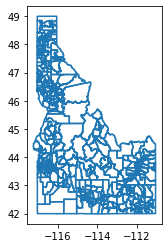

In [911]:
shapefiles_census.boundary.plot()

See the number of precincts in each county between the Census Phase 2 Release and the VEST file where the number of precincts is not the same. 

In [912]:
shapefiles_census.groupby('COUNTYFP')['VTDST'].count().compare(vest_id_18.groupby('COUNTYFP')['VTDST'].count() ) #, keep_shape = True, keep_equal = True)

,self,other
COUNTYFP,,
001,145.0,150.0
005,58.0,52.0
007,14.0,15.0
017,34.0,32.0
021,7.0,6.0
031,25.0,24.0
041,17.0,18.0
043,14.0,13.0
047,7.0,6.0


<AxesSubplot:>

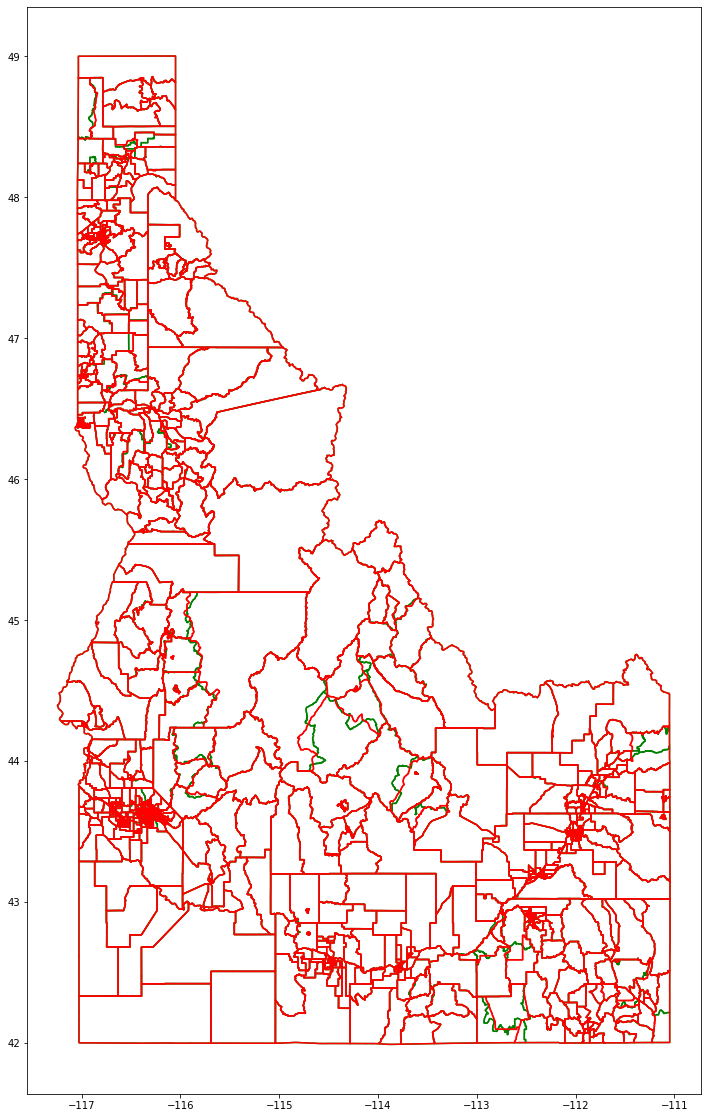

In [964]:
ax = shapefiles_census.boundary.plot(figsize=(20,20),color="green")
vest_id_18.boundary.plot(figsize=(20,20),ax=ax,color="red")